In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV 
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from numpy import maximum

In [2]:
dataset_targets = {
    "depression\\depression_transformed.csv": "History of Mental Illness",
    "diabetes\\diabetes_transformed.csv": "diabetes",
    "loan\\loan_transformed.csv": "charged_off",
    "weather\\weather_transformed.csv": "RainTomorrow"
}

In [3]:
def load_and_split(path, target_name, test_size=0.2, random_state=42):
    data = pd.read_csv(path)
    X=  data.drop(columns=[target_name])
    y = data[target_name]
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

In [4]:
X_train0, X_test0, y_train0, y_test0 = load_and_split(list(dataset_targets.keys())[0], dataset_targets[list(dataset_targets.keys())[0]])

In [5]:
X_train1, X_test1, y_train1, y_test1 = load_and_split(list(dataset_targets.keys())[1], dataset_targets[list(dataset_targets.keys())[1]])

In [6]:
X_train2, X_test2, y_train2, y_test2 = load_and_split(list(dataset_targets.keys())[2], dataset_targets[list(dataset_targets.keys())[2]])

In [7]:
X_train3, X_test3, y_train3, y_test3 = load_and_split(list(dataset_targets.keys())[3], dataset_targets[list(dataset_targets.keys())[3]])

In [8]:
model1 = XGBClassifier(random_state=42, tree_method = "hist", device = "cuda")
model2 = RandomForestClassifier(random_state=42)
model3 = LogisticRegression(random_state=42)

In [9]:
logistic_param_grid = {
    'C': np.logspace(-4, 4, 20),
    'penalty': ['elasticnet'],
    'l1_ratio': np.linspace(0, 1, 10),
    'solver': ['saga'],
    'max_iter': [1000, 2000, 5000]
}

xgb_param_grid = {
    "n_estimators": [300, 600, 900, 1200],
    "max_depth": [3, 4, 6, 8],
    "learning_rate": [0.01, 0.03, 0.1],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "min_child_weight": [1, 2, 5, 8],
    "gamma": [0.0, 1.0, 3.0],
    "reg_lambda": [0.0, 1.0, 5.0, 10.0],
    "reg_alpha": [0.0, 0.1, 1.0, 5.0],
    "scale_pos_weight": [1.0, 2.0, 5.0] 
}
forest_param_grid = {
    "n_estimators": [100, 300, 600, 1000],         # liczba drzew w lesie
    "max_depth": [None, 5, 10, 20, 30],            # maksymalna głębokość drzewa
    "min_samples_split": [2, 5, 10],               # minimalna liczba próbek do podziału węzła
    "min_samples_leaf": [1, 2, 4],                 # minimalna liczba próbek w liściu
    "max_features": ["sqrt", "log2", None],        # liczba cech branych pod uwagę przy podziale
    "bootstrap": [True, False],                    # czy używać bootstrapowania próbek
    "criterion": ["gini", "entropy", "log_loss"],  # funkcja oceny jakości podziału
    "class_weight": [None, "balanced"],            # dla niezbalansowanych danych
}

In [19]:
def tune(model, param_grid, X_train, y_train, scoring='roc_auc', n_iter_random=50, n_iter_bayes=50):
    random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=n_iter_random,
    cv=3, 
    scoring=scoring,
    verbose=1,
    random_state=42,
    n_jobs=-1 
    )

    random_search.fit(X_train, y_train)    
    
    opt = BayesSearchCV(
    estimator=model,
    search_spaces=param_grid,
    n_iter=n_iter_bayes,
    cv=3,
    scoring=scoring,      
    n_jobs=-1,
    random_state=42,
    refit=True,
    verbose=0,
    )
    
    opt.fit(X_train, y_train)
    return random_search, opt

In [20]:
def tune_for_each_data(model, param_grid, list_X_train, list_y_train, scoring='roc_auc'):
    import pandas as pd

    results_rs = []
    results_bs = []
    scores_rs = []
    all_results_df = []

    for i in range(len(list_X_train)):
        # Wywołanie funkcji tune dla danego zbioru danych
        rs, bs = tune(model, param_grid, list_X_train[i], list_y_train[i], scoring)

        # Zapis pełnych wyników
        results_rs.append(rs)
        results_bs.append(bs)

        # Wyciągnięcie wyników z RandomizedSearchCV
        rs_df = pd.DataFrame(rs.cv_results_)

        # Zachowanie parametrów oraz wyników testów
        params_df = pd.DataFrame(rs_df['params'].tolist())
        params_df['mean_test_score'] = rs_df['mean_test_score']
        params_df['dataset'] = f'dataset_{i+1}'
        
        all_results_df.append(params_df)
        scores_rs.append(rs_df['mean_test_score'])

    # Połączenie wszystkich wyników w jedną ramkę danych
    full_results_df = pd.concat(all_results_df, ignore_index=True)

    return results_rs, results_bs, scores_rs, full_results_df

In [ ]:
def plots_for_iterations(rs, bs):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
    random_iter = len(rs.cv_results_['mean_test_score'])
    bayes_iter = len(bs.cv_results_['mean_test_score'])

    rs_best = list(rs.cv_results_['mean_test_score'])
    bs_best = list(bs.cv_results_['mean_test_score'])
    rs_max_score = maximum.accumulate(rs.cv_results_["mean_test_score"])

    axes[0].plot(range(1, random_iter + 1), rs_best, label='RandomizedSearchCV', marker='o')    
    axes[0].plot(range(1, random_iter + 1), rs_max_score, color="orange", linestyle="--", label="Running best")
    axes[0].set_title('RandomizedSearchCV')
    axes[0].set_xlabel('Liczba iteracji')
    axes[0].legend()
    axes[0].grid()
    
    axes[1].plot(range(1, bayes_iter + 1), bs_best, label='BayesSearchCV', marker='x')
    axes[1].plot(range(1, bayes_iter + 1), bs_max_score, color="orange", linestyle="--", label="Running best")
    axes[1].set_title('BayesSearchCV')
    axes[1].set_xlabel('Liczba iteracji')
    axes[1].legend()
    axes[1].grid()

    axes[0].set_ylabel('Średni wynik testu')
    
    plt.suptitle("Porównanie postępu wyników dla RandomSearch i BayesSearch (XGBoost)", fontsize=14)
    plt.tight_layout()
    plt.show()

In [ ]:
def search_for_default(full_results_df):

    # Wyodrębnienie nazw kolumn odpowiadających hiperparametrom
    hyperparams = [col for col in full_results_df.columns if col not in ['mean_test_score', 'dataset']]

    # Uśrednienie wyników dla każdego zestawu hiperparametrów (po wszystkich zbiorach danych)
    df_grouped = full_results_df.groupby(hyperparams)['mean_test_score'].mean().reset_index()

    # Wybór najlepszego zestawu hiperparametrów
    best_idx = df_grouped['mean_test_score'].idxmax()
    best_params = df_grouped.loc[best_idx, hyperparams].to_dict()
    best_score = df_grouped.loc[best_idx, 'mean_test_score']

    # Posortowana tabela wszystkich kombinacji hiperparametrów
    df_sorted = df_grouped.sort_values('mean_test_score', ascending=False)

    return best_params, best_score, df_sorted


In [21]:
results_rs1, results_bs1, scores_rs1, full_results_df1 = tune_for_each_data(model1, xgb_param_grid, [X_train0, X_train1, X_train2, X_train3], [y_train0, y_train1, y_train2, y_train3])

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [23]:
results_rs2, results_bs2, scores_rs2, full_results_df2 = tune_for_each_data(model2, forest_param_grid, [X_train0, X_train1, X_train2, X_train3], [y_train0, y_train1, y_train2, y_train3])

Fitting 3 folds for each of 50 candidates, totalling 150 fits


KeyboardInterrupt: 

In [14]:
results_rs3, results_bs3, scores_rs3, full_results_df3 = tune_for_each_data(model3, logistic_param_grid, [X_train0, X_train1, X_train2, X_train3], [y_train0, y_train1, y_train2, y_train3])

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits


Model 1

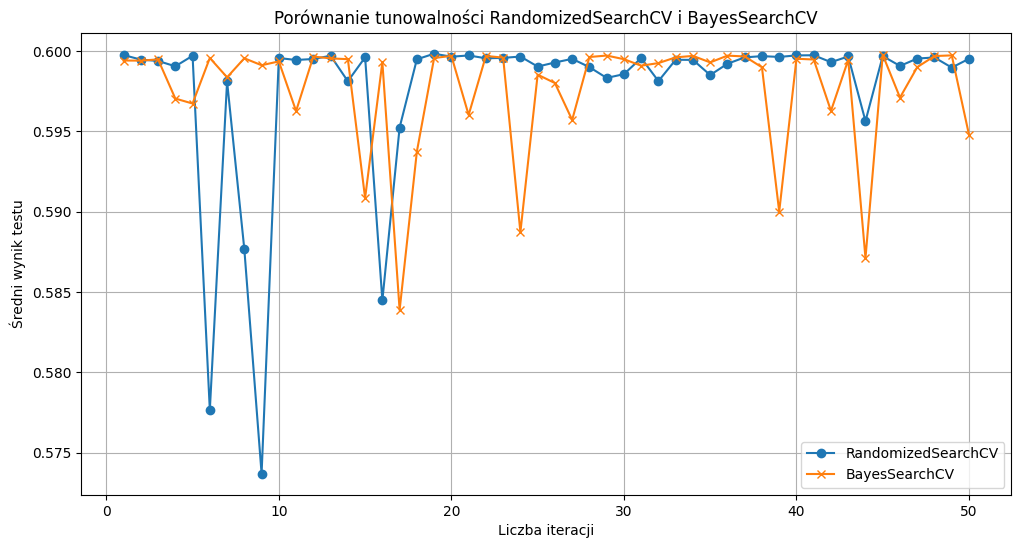

Najlepsze hiperparametry: {'subsample': 0.6, 'scale_pos_weight': 1.0, 'reg_lambda': 1.0, 'reg_alpha': 5.0, 'n_estimators': 900, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.03, 'gamma': 3.0, 'colsample_bytree': 0.6}
Najlepszy wynik: 0.5998429531024426


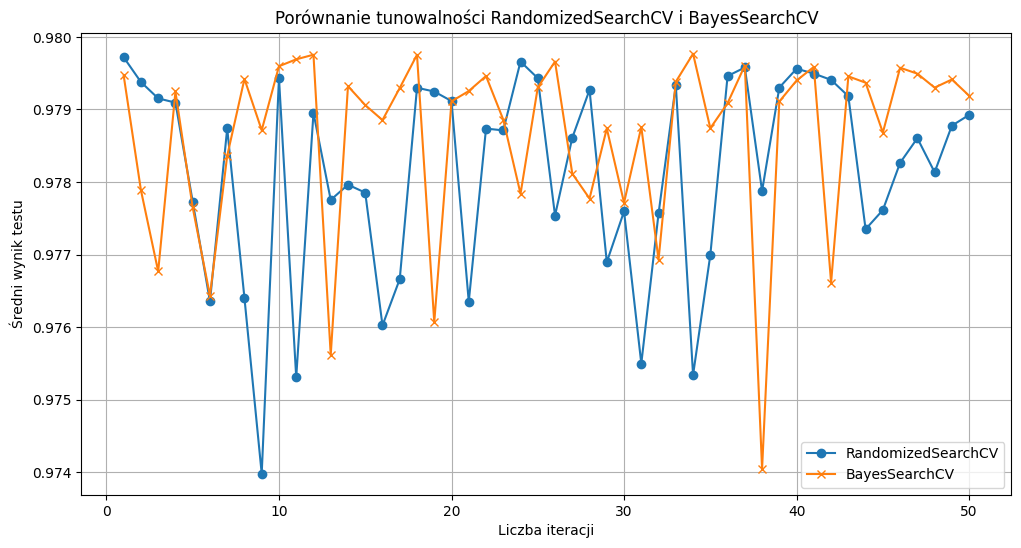

Najlepsze hiperparametry: {'subsample': 1.0, 'scale_pos_weight': 5.0, 'reg_lambda': 5.0, 'reg_alpha': 5.0, 'n_estimators': 900, 'min_child_weight': 8, 'max_depth': 3, 'learning_rate': 0.03, 'gamma': 1.0, 'colsample_bytree': 0.8}
Najlepszy wynik: 0.9797196706395592


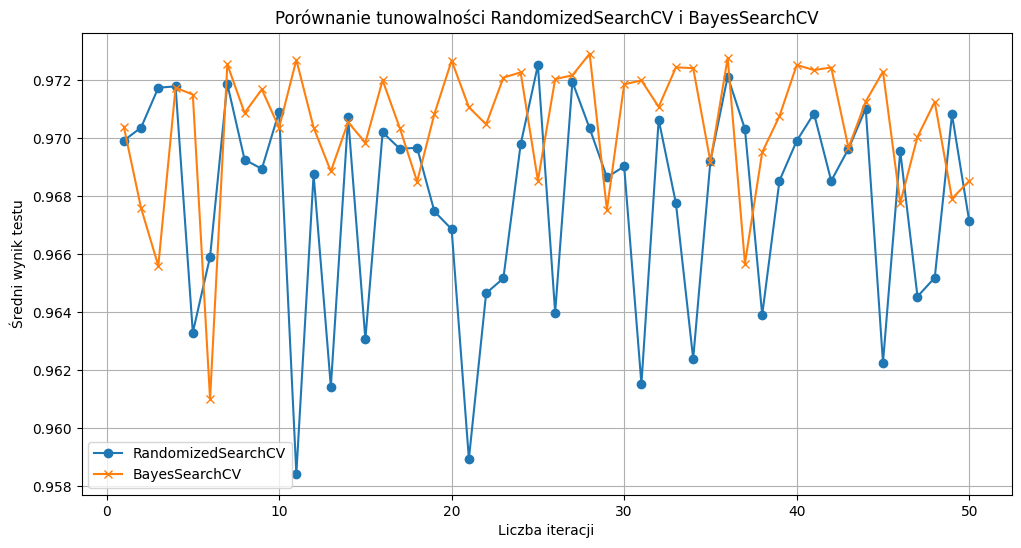

Najlepsze hiperparametry: {'subsample': 0.6, 'scale_pos_weight': 5.0, 'reg_lambda': 10.0, 'reg_alpha': 0.0, 'n_estimators': 900, 'min_child_weight': 2, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 1.0, 'colsample_bytree': 1.0}
Najlepszy wynik: 0.9725191380739493


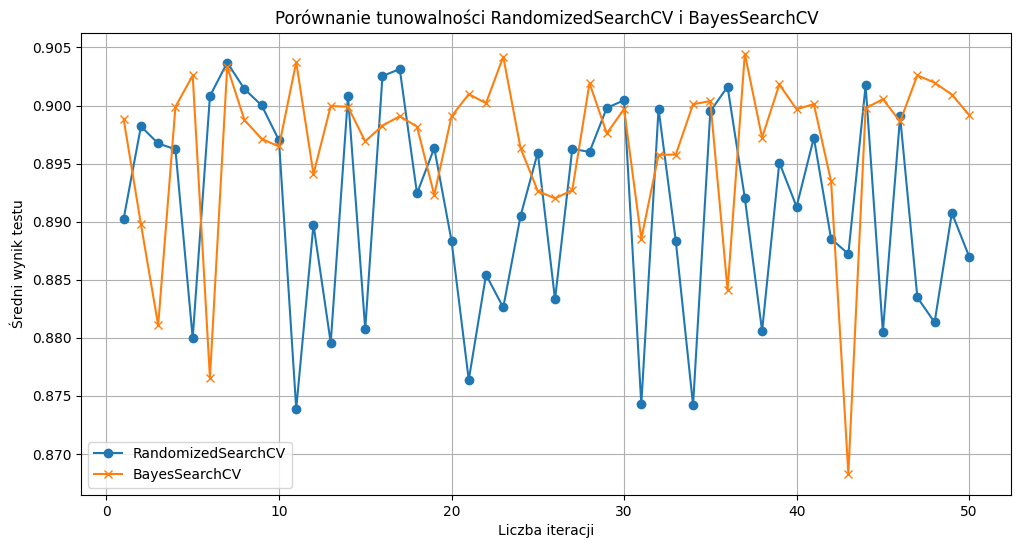

Najlepsze hiperparametry: {'subsample': 0.8, 'scale_pos_weight': 1.0, 'reg_lambda': 10.0, 'reg_alpha': 1.0, 'n_estimators': 1200, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.03, 'gamma': 1.0, 'colsample_bytree': 1.0}
Najlepszy wynik: 0.9037007711648792


In [24]:
for i in range(len(results_rs1)):
    plots_for_iterations(results_rs1[i], results_bs1[i])
    print('Najlepsze hiperparametry:', results_rs1[i].best_params_)
    print('Najlepszy wynik:', results_rs1[i].best_score_)

Model 2

In [ ]:
for i in range(len(results_rs2)):
    plots_for_iterations(results_rs2[i], results_bs2[i])
    print('Najlepsze hiperparametry:', results_rs2[i].best_params_)
    print('Najlepszy wynik:', results_rs2[i].best_score_)

Model 3

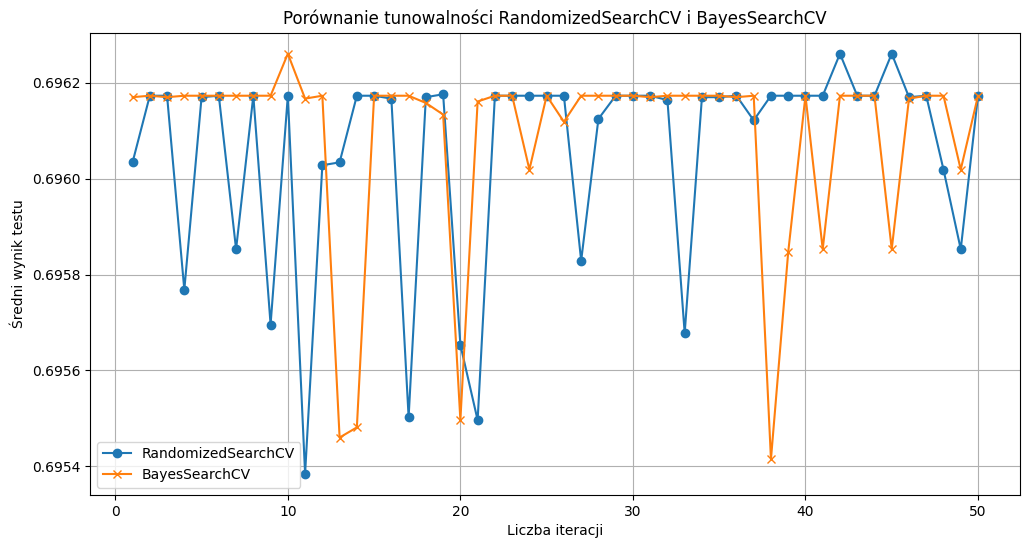

Najlepsze hiperparametry random: {'solver': 'saga', 'penalty': 'elasticnet', 'max_iter': 5000, 'l1_ratio': np.float64(1.0), 'C': np.float64(0.0001)}
Najlepszy wynik random: 0.696260581123457
Najlepsze hiperparametry bayes: OrderedDict({'C': 0.0001, 'l1_ratio': 0.8888888888888888, 'max_iter': 5000, 'penalty': 'elasticnet', 'solver': 'saga'})
Najlepszy wynik bayes: 0.696260581123457


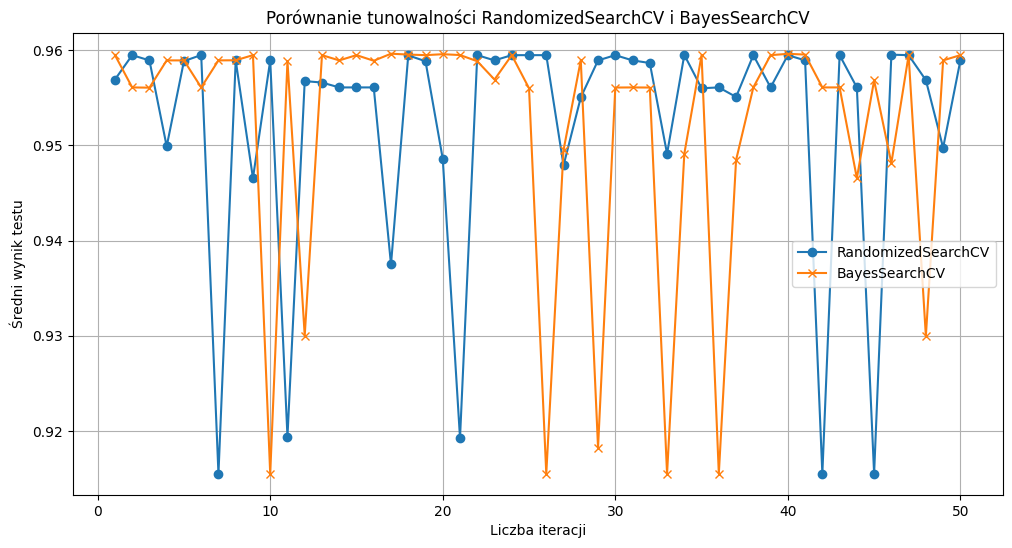

Najlepsze hiperparametry random: {'solver': 'saga', 'penalty': 'elasticnet', 'max_iter': 5000, 'l1_ratio': np.float64(0.0), 'C': np.float64(0.03359818286283781)}
Najlepszy wynik random: 0.9595174180987094
Najlepsze hiperparametry bayes: OrderedDict({'C': 0.03359818286283781, 'l1_ratio': 0.7777777777777777, 'max_iter': 5000, 'penalty': 'elasticnet', 'solver': 'saga'})
Najlepszy wynik bayes: 0.9596174370085674


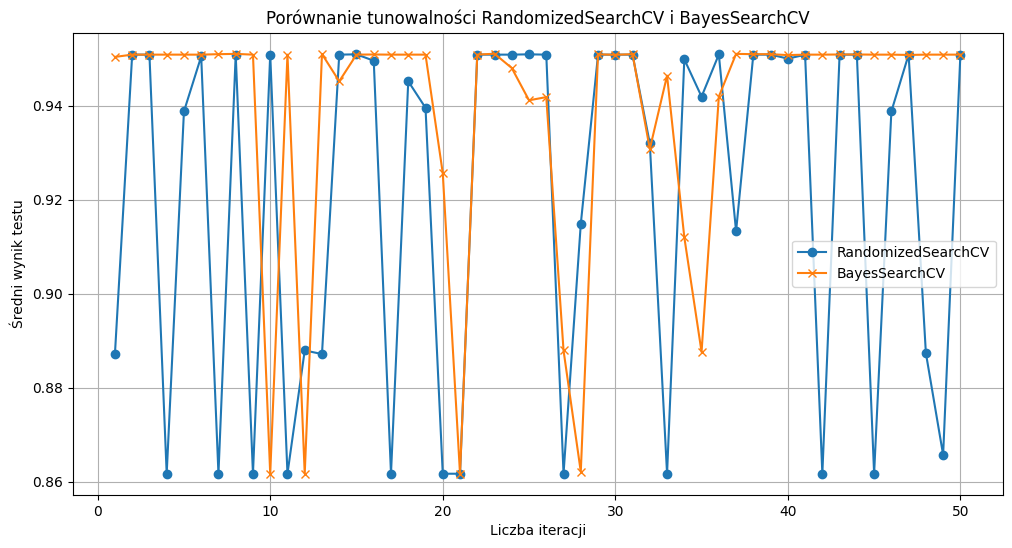

Najlepsze hiperparametry random: {'solver': 'saga', 'penalty': 'elasticnet', 'max_iter': 1000, 'l1_ratio': np.float64(0.3333333333333333), 'C': np.float64(11.288378916846883)}
Najlepszy wynik random: 0.9509397739034502
Najlepsze hiperparametry bayes: OrderedDict({'C': 0.615848211066026, 'l1_ratio': 1.0, 'max_iter': 1000, 'penalty': 'elasticnet', 'solver': 'saga'})
Najlepszy wynik bayes: 0.9510693810309236


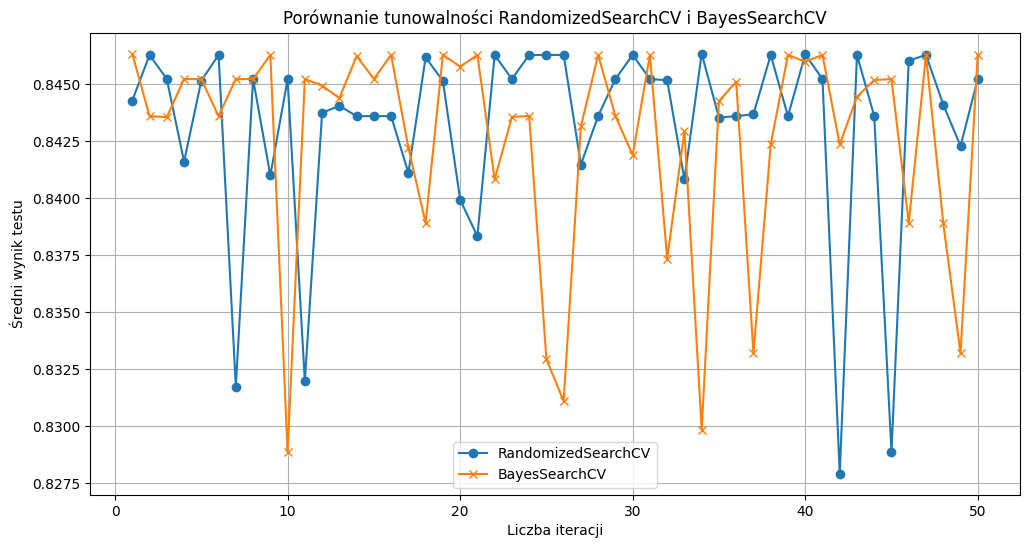

Najlepsze hiperparametry random: {'solver': 'saga', 'penalty': 'elasticnet', 'max_iter': 5000, 'l1_ratio': np.float64(0.5555555555555556), 'C': np.float64(0.23357214690901212)}
Najlepszy wynik random: 0.8463273224480373
Najlepsze hiperparametry bayes: OrderedDict({'C': 0.23357214690901212, 'l1_ratio': 0.7777777777777777, 'max_iter': 5000, 'penalty': 'elasticnet', 'solver': 'saga'})
Najlepszy wynik bayes: 0.8463184437400669


In [15]:
for i in range(len(results_rs3)):
    plots_for_iterations(results_rs3[i], results_bs3[i])
    print('Najlepsze hiperparametry random:', results_rs3[i].best_params_)
    print('Najlepszy wynik random:', results_rs3[i].best_score_)
    print('Najlepsze hiperparametry bayes:', results_bs3[i].best_params_)
    print('Najlepszy wynik bayes:', results_bs3[i].best_score_)

Default dla każdego modelu (na podstawie RandomSearch)

In [ ]:
best_params1, best_score1, df_sorted1 = search_for_default(full_results_df1)
best_params2, best_score2, df_sorted2 = search_for_default(full_results_df2)

In [16]:
best_params3, best_score3, df_sorted3 = search_for_default(full_results_df3)

In [18]:
print(best_params3, best_score3)

{'solver': 'saga', 'penalty': 'elasticnet', 'max_iter': 5000, 'l1_ratio': 0.2222222222222222, 'C': 11.288378916846883} 0.8632135514811633
